## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

In [2]:
def wrangle(path):
    df = pd.read_csv(path)

    # convert columns to lower case
    df.columns = df.columns.str.lower()

    # drop unimportant columns
    df = df.drop(columns= ['gradeclass', "studentid"])

    # reduce the precision of the studytimeweekly and gpa
    df['studytimeweekly'] = df['studytimeweekly'].round(2)
    df['gpa'] = df['gpa'].round(2)

    # create function to create grade column
    def assign_grades(gpa: float) -> int:
        if gpa >= 3.5:
            return 'First Class'  
        elif gpa >= 3.0:
            return 'Second Class Upper'  
        elif gpa >= 2.5:
            return 'Second Class Lower' 
        elif gpa >= 2.0:
            return 'Third Class'  
        else:
            return 'Pass' 

    # Map grades from gpa
    
    if 'gpa' in df.columns:
        df['grade'] = df['gpa'].apply(assign_grades)
    else:
        raise KeyError("Column 'gpa' is missing from the dataset.")

    return df



In [3]:
path = "Student_performance_data.csv"
df = wrangle(path)
df.head()

,age,gender,ethnicity,parentaleducation,studytimeweekly,absences,tutoring,parentalsupport,extracurricular,sports,music,volunteering,gpa,grade
0,17,1,0,2,19.83,7,1,2,0,0,1,0,2.93,Second Class Lower
1,18,0,0,1,15.41,0,0,1,0,0,0,0,3.04,Second Class Upper
2,15,0,2,3,4.21,26,0,2,0,0,0,0,0.11,Pass
3,17,1,0,3,10.03,14,0,3,1,0,0,0,2.05,Third Class
4,17,1,0,2,4.67,17,1,3,0,0,0,0,1.29,Pass


## Exploratory Data Analysis

In [4]:
# distribution of multiclass grades

df['grade'].value_counts(normalize= True) * 100

grade
Pass                  53.135452
Third Class           17.056856
Second Class Lower    16.095318
Second Class Upper    10.367893
First Class            3.344482
Name: proportion, dtype: float64

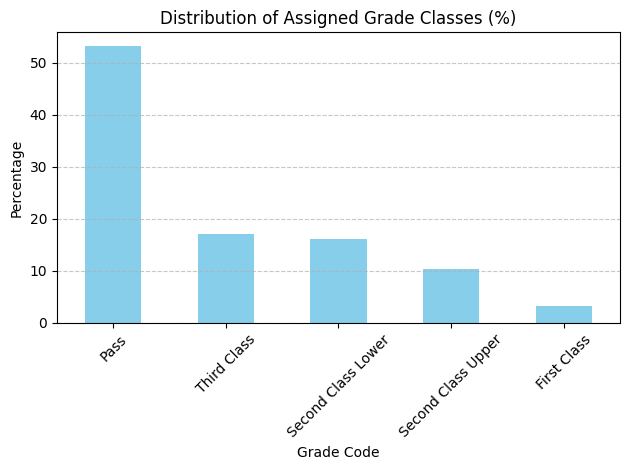

In [5]:
# visualize the distribution
(df['grade'].value_counts(normalize=True) * 100).round(2).plot(kind="bar", color="skyblue")
plt.title("Distribution of Assigned Grade Classes (%)")
plt.ylabel("Percentage")
plt.xlabel("Grade Code")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

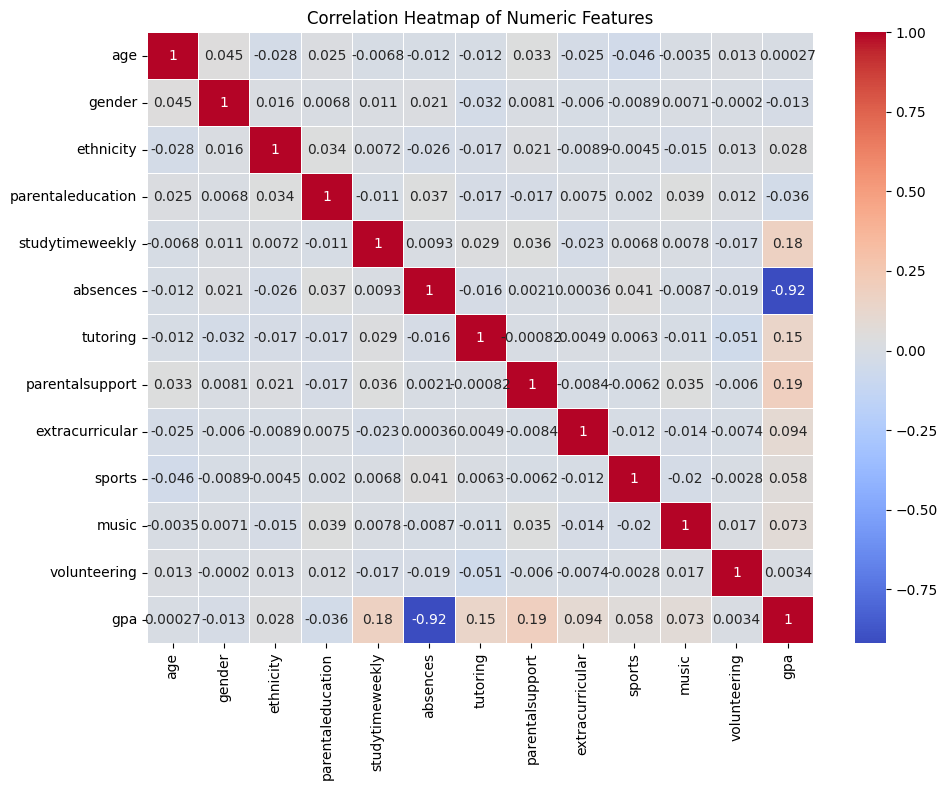

In [6]:
# visualizing the correlation heatmap of the features
plt.figure(figsize=(10, 8))
sns.heatmap(
    df.select_dtypes(exclude="object").corr(), 
    annot=True, 
    cmap="coolwarm", 
    linewidths=0.5
)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


## Machine Learning Dev

In [7]:
# Machine learning dev

target = 'grade'
X = df.drop(columns=[target, "gpa"])
y = df[target]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
# scale the features so it is on the same scale
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [10]:
lr = LogisticRegression(
    random_state=42
)

In [11]:
lr.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [12]:
# make predictions
lr_y_pred = lr.predict(X_test_scaled)

In [13]:
# evaluate the model
print(classification_report(y_test, lr_y_pred))

                    precision    recall  f1-score   support

       First Class       0.83      0.31      0.45        16
              Pass       0.93      0.95      0.94       254
Second Class Lower       0.66      0.68      0.67        77
Second Class Upper       0.70      0.76      0.73        50
       Third Class       0.60      0.59      0.59        82

          accuracy                           0.80       479
         macro avg       0.74      0.66      0.68       479
      weighted avg       0.80      0.80      0.80       479



In [14]:
# Generate the report as a dictionary
report_dict = classification_report(y_test, lr_y_pred, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Remove averages for focus
report_df = report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

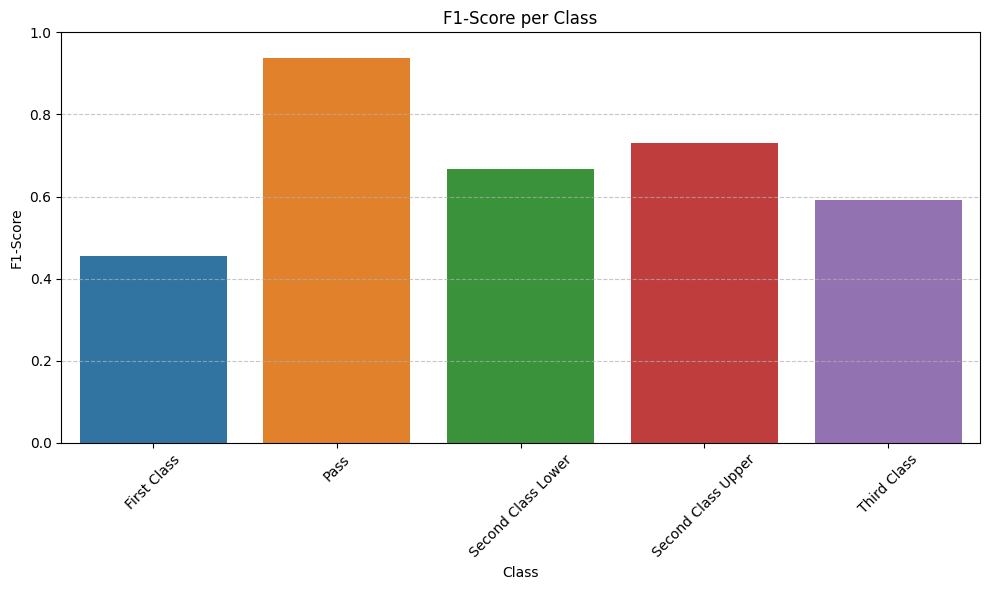

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y=report_df['f1-score'], hue = report_df.index, legend= False)
plt.title("F1-Score per Class")
plt.ylabel("F1-Score")
plt.xlabel("Class")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

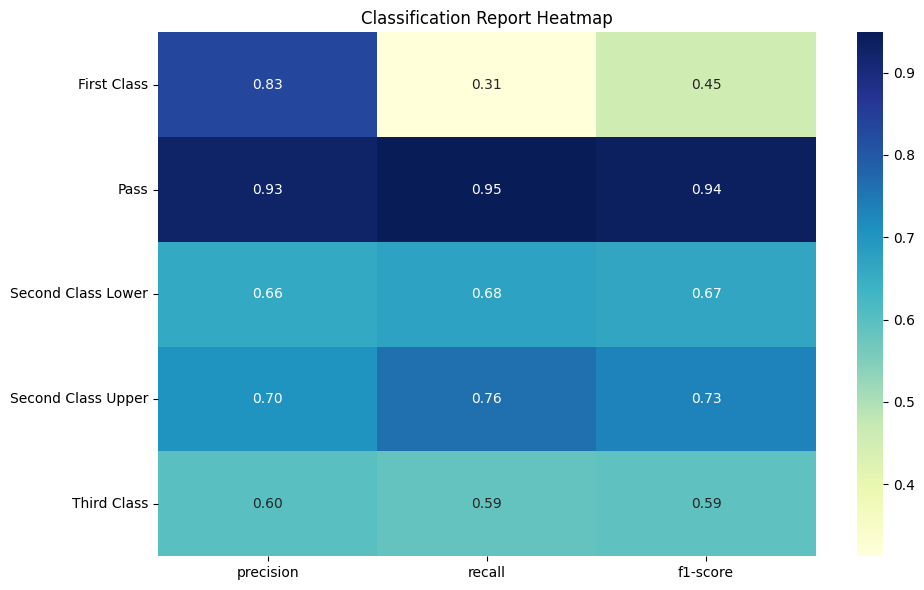

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(report_df[['precision', 'recall', 'f1-score']], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Random Forest Classifier

In [17]:
# train Random Forest Classifier
rf = RandomForestClassifier(
    random_state=42
)

In [18]:
rf.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
# make predictions
rf_y_pred = rf.predict(X_test_scaled)

In [20]:
# evaluate the model
print(classification_report(y_test, rf_y_pred))

                    precision    recall  f1-score   support

       First Class       0.62      0.31      0.42        16
              Pass       0.90      0.95      0.92       254
Second Class Lower       0.59      0.62      0.61        77
Second Class Upper       0.66      0.66      0.66        50
       Third Class       0.54      0.46      0.50        82

          accuracy                           0.76       479
         macro avg       0.66      0.60      0.62       479
      weighted avg       0.75      0.76      0.76       479



- It is seen that logistic regression model performs better than the Random forest model

In [21]:
feature_cols = X.columns
feature_cols

Index(['age', 'gender', 'ethnicity', 'parentaleducation', 'studytimeweekly',
       'absences', 'tutoring', 'parentalsupport', 'extracurricular', 'sports',
       'music', 'volunteering'],
      dtype='object')

In [22]:
# Feature importance
# We'll take the mean absolute value across classes
importances = np.mean(np.abs(lr.coef_), axis=0)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

In [23]:
# top 10 most import features needed to predict
feature_importance.head(10)

,feature,importance
5,absences,5.139876
7,parentalsupport,1.096284
4,studytimeweekly,0.976385
6,tutoring,0.729592
8,extracurricular,0.623253
9,sports,0.567592
10,music,0.340094
11,volunteering,0.088008
2,ethnicity,0.076322
0,age,0.067405


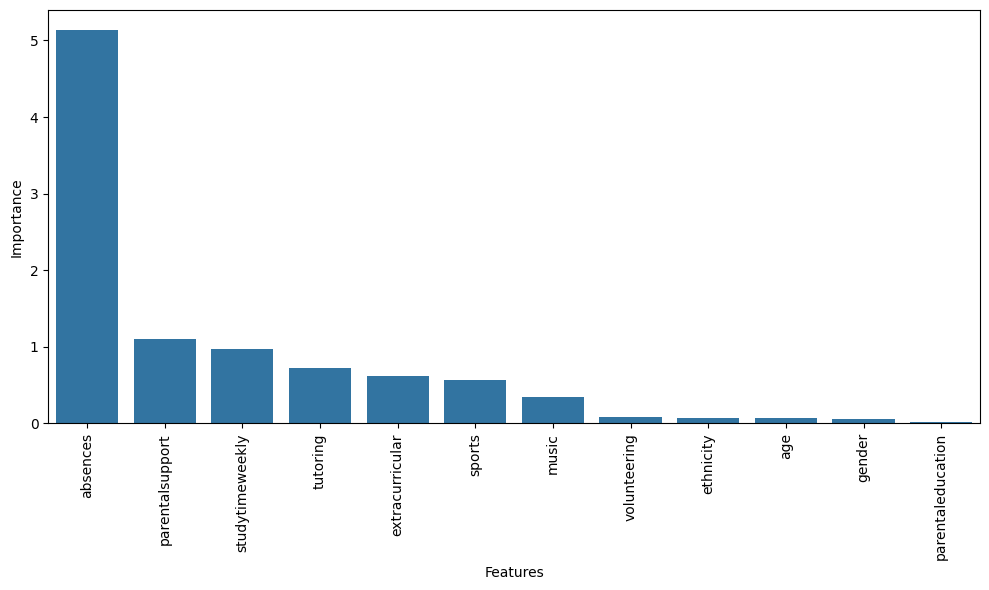

In [28]:
# visualize the feature importance
plt.figure(figsize=[10, 6])
sns.barplot(data= feature_importance,
           x= "feature",
           y="importance")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.xticks(rotation = 90)
plt.tight_layout();

In [25]:
# Save the model and scaler
joblib.dump(lr, 'student_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
# Save feature columns for API
joblib.dump(feature_cols, 'feature_columns.pkl')

['feature_columns.pkl']